# Linear quantum photonic circuit as variational quantum classifiers

The goal of this notebook is to reproduce the results from [this paper](https://arxiv.org/abs/2107.05224), which uses a Variational Quantum Circuit (VQC) for supervised learning. It tests a basic VQC with different inputs on three 2D datasets with binary labels: linear, circular and moon (more details on these later).

In this notebook, we will use [Perceval](https://perceval.quandela.net) for defining our quantum circuits, and we will use MerLin as our optimization tool which works splendidly with PyTorch.

## 0. Imports and prep

In [17]:
# Import required libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import perceval as pcvl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tqdm import tqdm
from math import comb
import random

# Import from our custom packages
from merlin import QuantumLayer, OutputMappingStrategy

## 1. Data preparation

Sample 200 points for each dataset: linear, circular and moon. Each datapoint has 2 features and a binary label (0 or 1).

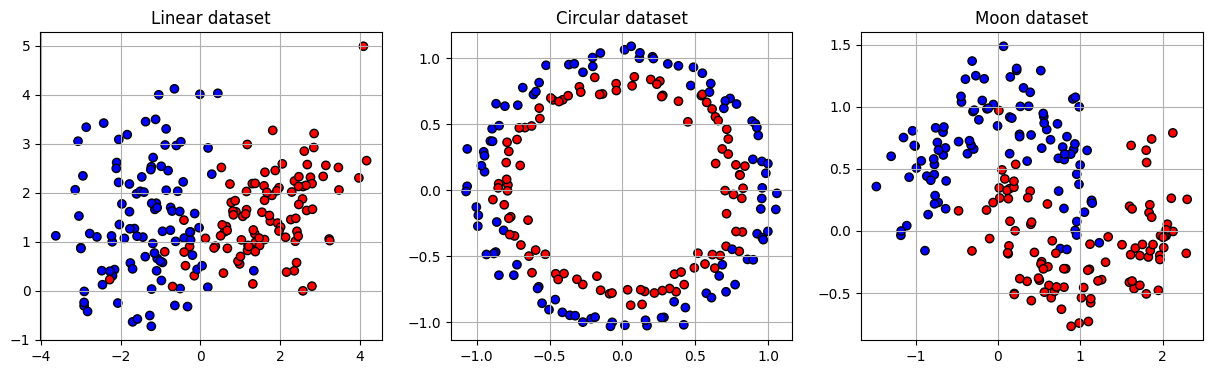

<Figure size 640x480 with 0 Axes>

In [3]:
def get_linear(num_samples, num_features, class_sep=1.5):
    """Generate linearly separable dataset with noise"""
    X, y = make_classification(
        n_samples=num_samples,  # number of data points
        n_features=num_features,  # 2D input
        n_informative=2,  # both features carry class information
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=2,
        random_state=42,
        class_sep=class_sep
    )
    return X, y


def get_circle(num_samples, noise=0.05):
    """Generate circularly separable dataset with noise"""
    X, y = make_circles(
        n_samples=num_samples,  # number of data points
        noise=noise,
        random_state=42
    )
    return X, y


def get_moon(num_samples, noise=0.2):
    """Generate moon dataset with noise"""
    X, y = make_moons(
        n_samples=num_samples,  # number of data points
        noise=noise,
        random_state=42
    )
    return X, y


def visual_sample(xs, ys, titles):
    """Visualize the generated datasets"""
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    i = 0
    for x, y, title in zip(xs, ys, titles):
        axs[i].scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', edgecolor='k')
        axs[i].set_title(title)
        axs[i].grid(True)
        i += 1
    plt.show()
    plt.clf()
    return

x_lin, y_lin = get_linear(200, 2, class_sep=1.5)
x_circ, y_circ = get_circle(200, noise=0.05)
x_moon, y_moon = get_moon(200, noise=0.2)

visual_sample([x_lin, x_circ, x_moon], [y_lin, y_circ, y_moon], ['Linear dataset', 'Circular dataset', 'Moon dataset'])

Then we standardize our data, change their type to torch.FloatTensor and split them into the training / test sets.

We'll only keep half of the data points to reproduce the VQC experiments faithfully.

In [4]:
def prepare_data():
    """Standardization, type changing and splitting of the data for preparation"""
    x_lin, y_lin = get_linear(200, 2, class_sep=1.5)
    x_circ, y_circ = get_circle(200, noise=0.05)
    x_moon, y_moon = get_moon(200, noise=0.2)

    # Take half of the data to have the same quantity as the paper
    x_lin, _, y_lin, _ = train_test_split(x_lin, y_lin, test_size=0.5, random_state=42)
    x_circ, _, y_circ, _ = train_test_split(x_circ, y_circ, test_size=0.5, random_state=42)
    x_moon, _, y_moon, _ = train_test_split(x_moon, y_moon, test_size=0.5, random_state=42)

    x_lin_train, x_lin_test, y_lin_train, y_lin_test = train_test_split(x_lin, y_lin, test_size=0.4, random_state=42)

    # Convert data to PyTorch tensors
    x_lin_train = torch.FloatTensor(x_lin_train)
    y_lin_train = torch.FloatTensor(y_lin_train)
    x_lin_test = torch.FloatTensor(x_lin_test)
    y_lin_test = torch.FloatTensor(y_lin_test)

    scaler = StandardScaler()
    x_lin_train = torch.FloatTensor(scaler.fit_transform(x_lin_train))
    x_lin_test = torch.FloatTensor(scaler.transform(x_lin_test))

    print(f"Linear training set: {x_lin_train.shape[0]} samples, {x_lin_train.shape[1]} features")
    print(f"Linear test set: {x_lin_test.shape[0]} samples, {x_lin_test.shape[1]} features")

    x_circ_train, x_circ_test, y_circ_train, y_circ_test = train_test_split(x_circ, y_circ, test_size=0.4, random_state=42)

    # Convert data to PyTorch tensors
    x_circ_train = torch.FloatTensor(x_circ_train)
    y_circ_train = torch.FloatTensor(y_circ_train)
    x_circ_test = torch.FloatTensor(x_circ_test)
    y_circ_test = torch.FloatTensor(y_circ_test)

    scaler = StandardScaler()
    x_circ_train = torch.FloatTensor(scaler.fit_transform(x_circ_train))
    x_circ_test = torch.FloatTensor(scaler.transform(x_circ_test))

    print(f"Circular training set: {x_circ_train.shape[0]} samples, {x_circ_train.shape[1]} features")
    print(f"Circular test set: {x_circ_test.shape[0]} samples, {x_circ_test.shape[1]} features")

    x_moon_train, x_moon_test, y_moon_train, y_moon_test = train_test_split(x_moon, y_moon, test_size=0.4, random_state=42)

    # Convert data to PyTorch tensors
    x_moon_train = torch.FloatTensor(x_moon_train)
    y_moon_train = torch.FloatTensor(y_moon_train)
    x_moon_test = torch.FloatTensor(x_moon_test)
    y_moon_test = torch.FloatTensor(y_moon_test)

    scaler = StandardScaler()
    x_moon_train = torch.FloatTensor(scaler.fit_transform(x_moon_train))
    x_moon_test = torch.FloatTensor(scaler.transform(x_moon_test))

    print(f"Moon training set: {x_moon_train.shape[0]} samples, {x_moon_train.shape[1]} features")
    print(f"Moon test set: {x_moon_test.shape[0]} samples, {x_moon_test.shape[1]} features")

    x_train = [x_lin_train, x_circ_train, x_moon_train]
    x_test = [x_lin_test, x_circ_test, x_moon_test]
    y_train = [y_lin_train, y_circ_train, y_moon_train]
    y_test = [y_lin_test, y_circ_test, y_moon_test]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = prepare_data()

Linear training set: 60 samples, 2 features
Linear test set: 40 samples, 2 features
Circular training set: 60 samples, 2 features
Circular test set: 40 samples, 2 features
Moon training set: 60 samples, 2 features
Moon test set: 40 samples, 2 features


## 2. Model definitions

First off, let's define our quantum circuit using Perceval. The variational parts of our circuit are beam splitter meshes.

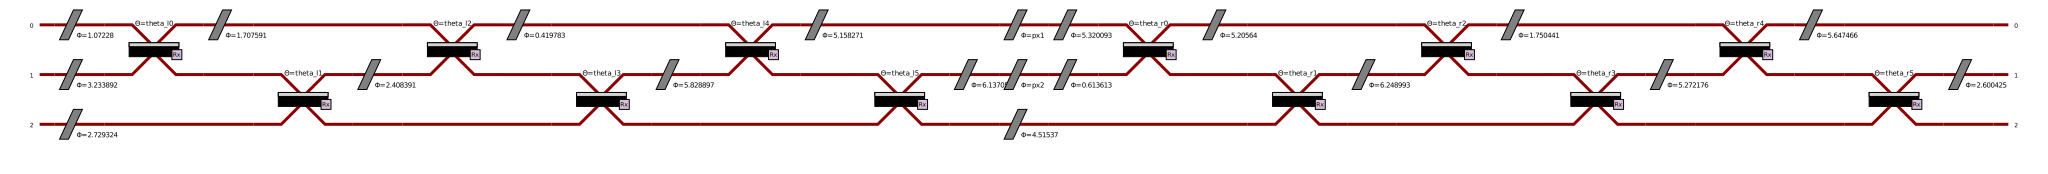

In [5]:
def create_vqc_bs_mesh(m, input_size):
    """Create variational quantum classifier with specified number of modes using beam splitter meshes"""

    # BS based circuits from https://perceval.quandela.net/docs/v0.13/notebooks/BS-based_implementation.html
    bs_l = pcvl.GenericInterferometer(m,
                                lambda idx: pcvl.BS(theta=pcvl.P("theta_l%d" % idx)) // (0, pcvl.PS(phi=np.pi * 2 * random.random())),
                                shape=pcvl.InterferometerShape.RECTANGLE,
                                depth=2 * m,
                                phase_shifter_fun_gen=lambda idx: pcvl.PS(phi=np.pi*2*random.random()))

    # Central part of the circuit encodes our data
    c_var = pcvl.Circuit(m)
    for i in range(input_size):
        px = pcvl.P(f"px{i + 1}")
        c_var.add(i + (m - input_size) // 2, pcvl.PS(px))

    # Other BS mesh
    bs_r = pcvl.GenericInterferometer(m,
                                lambda idx: pcvl.BS(theta=pcvl.P("theta_r%d" % idx)) // (0, pcvl.PS(phi=np.pi * 2 * random.random())),
                                shape=pcvl.InterferometerShape.RECTANGLE,
                                depth=2 * m,
                                phase_shifter_fun_gen=lambda idx: pcvl.PS(phi=np.pi*2*random.random()))

    c = pcvl.Circuit(m)
    c.add(0, bs_l, merge=True)
    c.add(0, c_var, merge=True)
    c.add(0, bs_r, merge=True)

    return c

def count_parameters(model):
    """Count trainable parameters in a PyTorch model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# In our case, we use 3 modes and have input size of 2 to have the same experiment set-up as the paper
vqc_bs_mesh = create_vqc_bs_mesh(3, 2)
# Let's visualize our circuit
pcvl.pdisplay(vqc_bs_mesh)

Now, we want to define our quantum layer as well as any other PyTorch layer used for the whole model.

The scale layer will be the input layer of the model, simply multiplying the input by a constant.

In [8]:
class ScaleLayer(nn.Module):
    """
        Multiply the input tensor by a learned or fixed factor.

        Args:
            dim (int): Dimension of the input data to be encoded.
            scale_type (str): Type of scaling method.

        Returns: nn.Module that multiplies the input tensor by a learned or fixed factor.
    """
    def __init__(self, dim, scale_type = "learned"):
        super(ScaleLayer, self).__init__()
        # Create a single learnable parameter (initialized to 1.0 by default)
        if scale_type == "learned":
            self.scale = nn.Parameter(torch.rand(dim))
        elif scale_type == "2pi":
            self.scale = torch.full((dim,), 2 * torch.pi)
        elif scale_type == "pi":
            self.scale = torch.full((dim,), torch.pi)
        elif scale_type == "/pi":
            self.scale = torch.full((dim,), 1 / torch.pi)
        elif scale_type == "1":
            self.scale = torch.full((dim,), 1)

    def forward(self, x):
        # Element-wise multiplication of each input element by the learned scale
        return x * self.scale

MerLin allows us to group a quantum layer with classical layers to form a hybrid model. The optimization of that model is as simple as any classical model optimization since MerLin was built to be compatible with PyTorch.

In [18]:
def get_vqc(m, input_size, initial_state, no_bunching=False, activation="none", scale_type="1"):
    """Build and return the hybrid model used for binary classification of 2D data"""

    # Get vqc circuit
    vqc_circuit = create_vqc_bs_mesh(m, input_size)
    n_photons = torch.sum(torch.tensor(initial_state))
    if no_bunching:
        # No bunching: C(n_modes, n_photons)
        output_size = comb(m, n_photons)
    else:
        # With bunching: C(n_modes + n_photons - 1, n_photons)
        output_size = comb(m + n_photons - 1, n_photons)

    input_layer = ScaleLayer(input_size, scale_type=scale_type)

    vqc = QuantumLayer(
            input_size=input_size,
            output_size=output_size,  # let MerLin handle the output size
            circuit=vqc_circuit,
            trainable_parameters=[p.name for p in vqc_circuit.get_parameters() if not p.name.startswith("px")],
            input_parameters=["px"],
            input_state= initial_state, # [1, 0, 0] for example
            no_bunching=no_bunching,
            output_mapping_strategy=OutputMappingStrategy.NONE  # We will handle the outputting ourselves
        )

    # The last Linear layer acts as the observable, and it makes sure the output is 1 dimensional

    if activation == "none":
        classification_layer = nn.Linear(vqc.output_size, 1)
        complete_vqc = nn.Sequential(input_layer, vqc, classification_layer)

    elif activation == "sigmoid":
        classification_layer = nn.Linear(vqc.output_size, 1)
        complete_vqc = nn.Sequential(input_layer, vqc, classification_layer, nn.Sigmoid())

    elif activation == "softmax":
        classification_layer = nn.Linear(vqc.output_size, 2)
        complete_vqc = nn.Sequential(input_layer, vqc, classification_layer, nn.Softmax(dim=1))

    else:
        raise ValueError(f"Activation function unknown or not implemented: '{activation}'")

    return complete_vqc

Let\'s also define some MultiLayer Perceptrons (MLP) for comparison with classical models. However, we will use small models so the number of parameters are similar between the two.

In [19]:
def get_mlp_deep(input_size, activation):
    """Build and return a small 2-hidden-layers MLP for binary classification"""
    classical_layer_1 = nn.Linear(input_size, 2)
    classical_layer_2 = nn.Linear(2, 3)

    if activation == "none":
        mlp = nn.Sequential(classical_layer_1, nn.ReLU(), classical_layer_2, nn.ReLU(), nn.Linear(3, 1))

    elif activation == "sigmoid":
        mlp = nn.Sequential(classical_layer_1, nn.ReLU(), classical_layer_2, nn.ReLU(), nn.Linear(3, 1),
                                     nn.Sigmoid())

    elif activation == "softmax":
        mlp = nn.Sequential(classical_layer_1, nn.ReLU(), classical_layer_2, nn.ReLU(), nn.Linear(3, 2),
                                     nn.Softmax(dim=1))
    else:
        raise ValueError(f"Activation function unknown or not implemented: '{activation}'")

    return mlp


def get_mlp_wide(input_size, activation):
    """Build and return a small 1-hidden-layers MLP for binary classification"""
    classical_layer_1 = nn.Linear(input_size, 4)

    if activation == "none":
        mlp = nn.Sequential(classical_layer_1, nn.ReLU(), nn.Linear(4, 1))

    elif activation == "sigmoid":
        mlp = nn.Sequential(classical_layer_1, nn.ReLU(), nn.Linear(4, 1),
                                     nn.Sigmoid())

    elif activation == "softmax":
        mlp = nn.Sequential(classical_layer_1, nn.ReLU(), nn.Linear(4, 2),
                                     nn.Softmax(dim=1))
    else:
        raise ValueError(f"Activation function unknown or not implemented: '{activation}'")

    return mlp

## 3. Training function


The training of the hybrid model has the exact same structure as the normal training of a classical model using PyTorch.

In [20]:
def train_model(model, model_name, X_train, X_test, y_train, y_test, args):
    """Train a model and return training metrics"""
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=args.betas)
    criterion = nn.MSELoss()  # loss from paper

    losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()

    pbar = tqdm(range(args.n_epochs), desc=f"Training {model_name}")
    for epoch in pbar:
        permutation = torch.randperm(X_train.size()[0])
        total_loss = 0

        for i in range(0, X_train.size()[0], args.batch_size):
            indices = permutation[i:i + args.batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            # If softmax activation, we have to format the labels in 2-dimensions
            if args.activation == "softmax":
                # One-hot encode
                batch_y = F.one_hot(batch_y.squeeze().long(), num_classes=2).float()  # shape : (batch_size, 2)

            outputs = model(batch_x)

            # Get the right parameters for regularization
            if args.regu_on == "linear":
                # Get the observable parameters
                if args.activation == "none":
                    obs = list(model[-1].parameters())
                else:
                    obs = list(model[-2].parameters())
                # Flatten all tensors and concatenate into a single vector
                obs_vector = torch.cat([p.view(-1) for p in obs])

            elif args.regu_on == "all":
                # Get the observable parameters
                obs = list(model.parameters())
                # Flatten all tensors and concatenate into a single vector
                obs_vector = torch.cat([p.view(-1) for p in obs])

            else:
                raise NotImplementedError

                #  [                      MSE                    ] + [                regularization                    ]
            loss = criterion(outputs.squeeze(), batch_y.squeeze()) + args.alpha * torch.linalg.vector_norm(obs_vector)**2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (X_train.size()[0] // args.batch_size)
        losses.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train)

            if args.activation == "softmax":
                train_preds = torch.argmax(train_outputs, dim=1)
            else:
                train_preds = torch.round(train_outputs)

            train_acc = accuracy_score(y_train.numpy(), train_preds.cpu().numpy())
            train_accuracies.append(train_acc)

            test_outputs = model(X_test)

            if args.activation == "softmax":
                test_preds = torch.argmax(test_outputs, dim=1)
            else:
                test_preds = torch.round(test_outputs)

            test_acc = accuracy_score(y_test.numpy(), test_preds)
            test_accuracies.append(test_acc)

            pbar.set_description(f"Training {model_name} - Loss: {avg_loss:.4f}, Test Acc: {test_acc:.4f}")

        model.train()

    return {
        'losses': losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_test_acc': test_accuracies[-1]
    }

We define the function train_model_multiple_runs() so that it is a general function that can be used for different types of model.

In [21]:
def train_model_multiple_runs(type, args):
    """
    Train model multiple times and return results

    Parameters
    ----------
    type : String, must be in this list ["vqc", "mlp_deep", "mlp_wide", "svm_lin", "svm_rbf"]
        Indicates which type of model to train.

    args : Arguments object
        Contains arguments passed to the model or useful for training

    Returns
    -------
    Dictionary
        Contains the results of several runs of the model.
    """

    X_trains, X_tests, y_trains, y_tests = prepare_data()
    datasets = ["linear", "circular", "moon"]
    best_models = []
    best_accs = []
    results = {}

    for i, dataset in enumerate(datasets):
        X_train = X_trains[i]
        X_test = X_tests[i]
        y_train = y_trains[i]
        y_test = y_tests[i]

        if type == "vqc":
            print(f"\nTraining VQC with dataset {dataset} ({args.num_runs} runs):")
            models = []
            model_runs = []

            for run in range(args.num_runs):

                # Create a fresh instance of the model for each run
                model = get_vqc(args.m, args.input_size, args.initial_state, activation=args.activation, no_bunching=args.no_bunching, scale_type=args.scale_type)
                num_params = count_parameters(model)

                print(f"  Run {run + 1}/{args.num_runs}, VQC has {num_params} parameters...")
                args.set_dataset_name(dataset)

                run_results = train_model(model, f"VQC with dataset {dataset} (run{run + 1})", X_train, X_test, y_train, y_test, args)
                models.append(model)
                model_runs.append(run_results)

        elif type[:3] == "mlp":
            if type == "mlp_wide":
                network_type = "wide"
                get_mlp = get_mlp_wide
            elif type == "mlp_deep":
                network_type = "deep"
                get_mlp = get_mlp_deep
            else:
                raise NotImplementedError

            print(f"\nTraining MLP ({network_type}) with dataset {dataset} ({args.num_runs} runs):")
            models = []
            model_runs = []

            for run in range(args.num_runs):
                # Create a fresh instance of the model for each run
                model = get_mlp(args.input_size, activation=args.activation)

                num_params = count_parameters(model)

                print(f"  Run {run + 1}/{args.num_runs}, MLP has {num_params} parameters...")
                args.set_dataset_name(dataset)
                run_results = train_model(model, f"MLP with dataset {dataset} (run{run + 1})", X_train, X_test, y_train, y_test, args)
                models.append(model)
                model_runs.append(run_results)

        else:
            if type == "svm_lin":
                kernel = "linear"
            elif type == "svm_rbf":
                kernel = "rbf"
            else:
                raise NotImplementedError

            print(f"\nTraining SVM ({kernel}) with dataset {dataset} ({args.num_runs} runs):")
            models = []
            model_runs = []

            for run in range(args.num_runs):
                # Create a fresh instance of the model for each run
                model = SVC(kernel=kernel, gamma="scale")
                model.fit(X_train, y_train)

                print(f"  Run {run + 1}/{args.num_runs}, SVM ({kernel})...")
                args.set_dataset_name(dataset)

                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                models.append(model)
                run_results = {
                    'losses': [0.0] * args.n_epochs,
                    'train_accuracies': [0.0] * args.n_epochs,
                    'test_accuracies': [0.0] * args.n_epochs,
                    'final_test_acc': accuracy
                }
                model_runs.append(run_results)


        best_run = torch.argmax(torch.Tensor([run["final_test_acc"] for run in model_runs]))
        best_accs.append(torch.max(torch.Tensor([run["final_test_acc"] for run in model_runs])))
        best_models.append(models[best_run])

        # Store all runs for this model
        results[dataset] = {
            'runs': model_runs,
            # Calculate aggregate statistics
            'avg_final_test_acc': sum(run['final_test_acc'] for run in model_runs) / args.num_runs
        }

    visualize_decision_boundary(type, best_models, X_trains, X_tests, y_trains, y_tests, args, best_accs)

    return results


def train_vqc_multiple_runs(args):
    """Train VQC several times"""
    return train_model_multiple_runs("vqc", args)


def train_mlp_multiple_runs(args, network_type="wide"):
    """Train MLP of {network_type} several times"""
    if network_type == "wide":
        return train_model_multiple_runs("mlp_wide", args)
    elif network_type == "deep":
        return train_model_multiple_runs("mlp_deep", args)
    else:
        raise NotImplementedError


def train_svm_multiple_runs(args, kernel_type="lin"):
    """Train SVM of {kernel_type} several times"""
    if kernel_type == "lin":
        return train_model_multiple_runs("svm_lin", args)
    elif kernel_type == "rbf":
        return train_model_multiple_runs("svm_rbf", args)
    else:
        raise NotImplementedError

We also want a function to visualize the decision boundary of our models.

In [22]:
def visualize_decision_boundary(type, models, X_trains, X_tests, y_trains, y_tests, args, final_accs, resolution=100, device="cpu"):
    """Visualize the decision boundaries of the trained models on the three datasets"""
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    datasets = ["linear", "circular", "moon"]
    i = 0

    model_name = type

    if type == "vqc":
        model_name += f"_{args.initial_state}"

    for model, dataset, acc, X_train, X_test, y_train, y_test in zip(models, datasets, final_accs, X_trains, X_tests, y_trains, y_tests):

        # Convert to numpy if X_train is a tensor
        if isinstance(X_train, torch.Tensor):
            X_train_np = X_train.cpu().numpy()
        else:
            X_train_np = X_train

        # Convert to numpy if X_test is a tensor
        if isinstance(X_test, torch.Tensor):
            X_test_np = X_test.cpu().numpy()
        else:
            X_test_np = X_test

        # Determine plot boundaries
        x_min1, x_max1 = X_train_np[:, 0].min() - 1, X_train_np[:, 0].max() + 1
        y_min1, y_max1 = X_train_np[:, 1].min() - 1, X_train_np[:, 1].max() + 1
        x_min2, x_max2 = X_test_np[:, 0].min() - 1, X_test_np[:, 0].max() + 1
        y_min2, y_max2 = X_test_np[:, 1].min() - 1, X_test_np[:, 1].max() + 1

        x_min = min(x_min1, x_min2)
        x_max = max(x_max1, x_max2)
        y_min = min(y_min1, y_min2)
        y_max = max(y_max1, y_max2)

        # Create a meshgrid
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, resolution),
            np.linspace(y_min, y_max, resolution)
        )
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        if type == "vqc" or type[:3] == "mlp":
            # Ensure model is in eval mode and on the correct device
            model.eval()
            model.to(device)

            # Convert to torch tensor
            grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

            # Predict with the model (no gradient needed)
            with torch.no_grad():
                preds = model(grid_tensor).squeeze()

            if args.activation == "none":
                probs = preds.cpu().numpy()
            elif args.activation == "softmax":
                probs = preds[:, 1].cpu().numpy()
            else:
                probs = preds.cpu().numpy()

        elif type == "svm_lin" or type == "svm_rbf":
            probs = model.predict(grid_points)

        else:
            raise NotImplementedError

        # Convert to 0 or 1 prediction
        pred_labels = (probs > 0.5).astype(int)

        # Plot decision boundary
        axs[i].contourf(xx, yy, pred_labels.reshape(xx.shape), alpha=0.3, cmap=plt.cm.RdBu)

        # Plot train points
        axs[i].scatter(
            X_train_np[:, 0], X_train_np[:, 1],
            c=y_train, cmap=plt.cm.RdBu, s=30, marker="o", label="Training data"
        )

        # Plot test points
        axs[i].scatter(
            X_test_np[:, 0], X_test_np[:, 1],
            c=y_test, cmap=plt.cm.RdBu, s=30, marker="x", label="Test data"
        )

        # Format the accuracy to 2 decimal places
        formatted_acc = f"{acc:.2f}"

        # Place it in axes coordinates (0,1 is top-left)
        axs[i].text(0.01, 0.99, formatted_acc, transform=axs[i].transAxes,
                ha='left', va='top', fontsize=12)

        axs[i].set_xlabel("x1")
        axs[i].set_ylabel("x2")
        axs[i].set_title(f"Decision boundary of {model_name} on {dataset} dataset", fontsize=10)
        legend_elements = [
            Patch(facecolor='red', label='Label 0'),
            Patch(facecolor='blue', label='Label 1'),
            Line2D([0], [0], marker='o', color='gray', label='Training data', markerfacecolor='gray', markersize=8),
            Line2D([0], [0], marker='x', color='gray', label='Test data', markerfacecolor='gray', markersize=8)
        ]

        axs[i].legend(handles=legend_elements, loc='upper right')
        i += 1

    # plt.savefig(f"./results/decision_boundaries_{model_name}.png")  # To save the figure locally
    plt.show()
    plt.clf()
    return

## 4. Run the training

The hyperparameters for our experiment:

In [23]:
# Hyperparameters and experimental set-up
m = 3
input_size = 2
initial_state = [1, 0, 0]

activation = "none"  # ["none", "sigmoid", "softmax"]
no_bunching = False
num_runs = 5
n_epochs = 100
batch_size = 32
lr = 0.02
alpha = 0.002
betas = (0.85, 0.999)
scale_type = "/pi"  # ["learned", "2pi", "pi", "/pi", "1"]
regu_on = "linear"  # ["linear", "all"]

Class Argument contains the information needed.

In [24]:
class Arguments:
    def __init__(self, m, input_size, initial_state, activation="none", no_bunching=False, num_runs=5, n_epochs=50,
                 batch_size=32, lr=0.02, alpha=0.2, betas=(0.9, 0.999), scale_type="learned", regu_on="linear"):
        self.m = m
        self.input_size = input_size
        self.initial_state = initial_state
        self.activation = activation
        self.no_bunching = no_bunching
        self.num_runs = num_runs
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.alpha = alpha
        self.betas = betas
        self.scale_type = scale_type
        self.regu_on = regu_on
        self.dataset_name = ""

    def set_dataset_name(self, dataset):
        self.dataset_name = dataset
        return

Train VQC with initial state \[1, 0, 0] and show the decision boundary.

Linear training set: 60 samples, 2 features
Linear test set: 40 samples, 2 features
Circular training set: 60 samples, 2 features
Circular test set: 40 samples, 2 features
Moon training set: 60 samples, 2 features
Moon test set: 40 samples, 2 features

Training VQC with dataset linear (5 runs):
  Run 1/5, VQC has 16 parameters...


Training VQC with dataset linear (run1) - Loss: 0.0866, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 20.12it/s]


  Run 2/5, VQC has 16 parameters...


Training VQC with dataset linear (run2) - Loss: 0.0911, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 20.14it/s]


  Run 3/5, VQC has 16 parameters...


Training VQC with dataset linear (run3) - Loss: 0.0898, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 21.09it/s]


  Run 4/5, VQC has 16 parameters...


Training VQC with dataset linear (run4) - Loss: 0.0876, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 21.00it/s]


  Run 5/5, VQC has 16 parameters...


Training VQC with dataset linear (run5) - Loss: 0.0883, Test Acc: 0.8750: 100%|██████████| 100/100 [00:05<00:00, 18.49it/s]



Training VQC with dataset circular (5 runs):
  Run 1/5, VQC has 16 parameters...


Training VQC with dataset circular (run1) - Loss: 0.2853, Test Acc: 0.9250: 100%|██████████| 100/100 [00:04<00:00, 21.23it/s]


  Run 2/5, VQC has 16 parameters...


Training VQC with dataset circular (run2) - Loss: 0.3436, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 21.51it/s]


  Run 3/5, VQC has 16 parameters...


Training VQC with dataset circular (run3) - Loss: 0.3952, Test Acc: 0.8250: 100%|██████████| 100/100 [00:04<00:00, 21.15it/s]


  Run 4/5, VQC has 16 parameters...


Training VQC with dataset circular (run4) - Loss: 0.3550, Test Acc: 0.9000: 100%|██████████| 100/100 [00:04<00:00, 20.82it/s]


  Run 5/5, VQC has 16 parameters...


Training VQC with dataset circular (run5) - Loss: 0.3834, Test Acc: 0.7250: 100%|██████████| 100/100 [00:04<00:00, 21.51it/s]



Training VQC with dataset moon (5 runs):
  Run 1/5, VQC has 16 parameters...


Training VQC with dataset moon (run1) - Loss: 0.1988, Test Acc: 0.8000: 100%|██████████| 100/100 [00:04<00:00, 20.02it/s]


  Run 2/5, VQC has 16 parameters...


Training VQC with dataset moon (run2) - Loss: 0.2061, Test Acc: 0.8000: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


  Run 3/5, VQC has 16 parameters...


Training VQC with dataset moon (run3) - Loss: 0.2073, Test Acc: 0.8000: 100%|██████████| 100/100 [00:04<00:00, 21.36it/s]


  Run 4/5, VQC has 16 parameters...


Training VQC with dataset moon (run4) - Loss: 0.2034, Test Acc: 0.8000: 100%|██████████| 100/100 [00:04<00:00, 20.13it/s]


  Run 5/5, VQC has 16 parameters...


Training VQC with dataset moon (run5) - Loss: 0.2019, Test Acc: 0.8000: 100%|██████████| 100/100 [00:04<00:00, 21.12it/s]


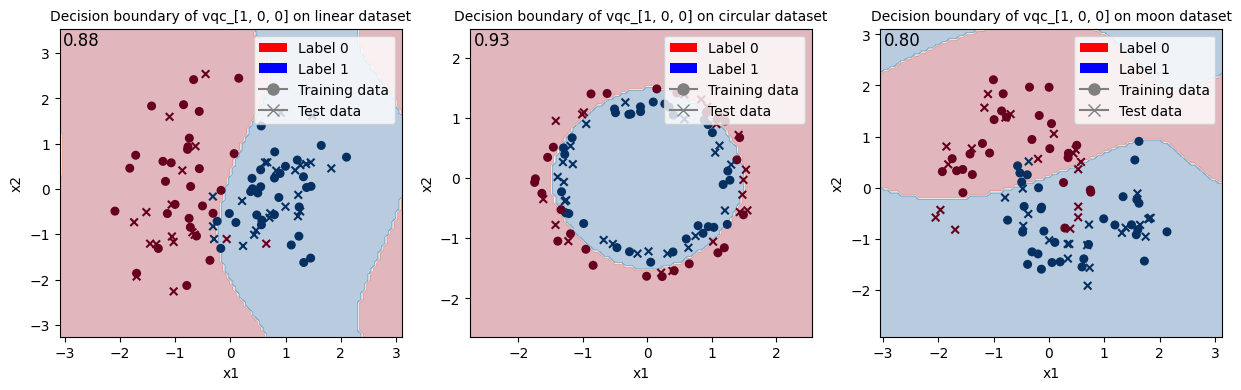

<Figure size 640x480 with 0 Axes>

In [25]:
# VQC [1, 0, 0]
args = Arguments(m, input_size, [1, 0, 0], activation, no_bunching, num_runs, n_epochs, batch_size, lr, alpha, betas, scale_type, regu_on)
vqc_100_results = train_vqc_multiple_runs(args)

Train VQC with initial state \[1, 1, 1] and show the decision boundary.

Linear training set: 60 samples, 2 features
Linear test set: 40 samples, 2 features
Circular training set: 60 samples, 2 features
Circular test set: 40 samples, 2 features
Moon training set: 60 samples, 2 features
Moon test set: 40 samples, 2 features

Training VQC with dataset linear (5 runs):
  Run 1/5, VQC has 23 parameters...


Training VQC with dataset linear (run1) - Loss: 0.0846, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 21.61it/s]


  Run 2/5, VQC has 23 parameters...


Training VQC with dataset linear (run2) - Loss: 0.0871, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 22.78it/s]


  Run 3/5, VQC has 23 parameters...


Training VQC with dataset linear (run3) - Loss: 0.0951, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


  Run 4/5, VQC has 23 parameters...


Training VQC with dataset linear (run4) - Loss: 0.0943, Test Acc: 0.9250: 100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


  Run 5/5, VQC has 23 parameters...


Training VQC with dataset linear (run5) - Loss: 0.0833, Test Acc: 0.8750: 100%|██████████| 100/100 [00:05<00:00, 19.61it/s]



Training VQC with dataset circular (5 runs):
  Run 1/5, VQC has 23 parameters...


Training VQC with dataset circular (run1) - Loss: 0.2946, Test Acc: 0.7000: 100%|██████████| 100/100 [00:04<00:00, 20.49it/s]


  Run 2/5, VQC has 23 parameters...


Training VQC with dataset circular (run2) - Loss: 0.2900, Test Acc: 0.7250: 100%|██████████| 100/100 [00:04<00:00, 20.48it/s]


  Run 3/5, VQC has 23 parameters...


Training VQC with dataset circular (run3) - Loss: 0.2773, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 20.48it/s]


  Run 4/5, VQC has 23 parameters...


Training VQC with dataset circular (run4) - Loss: 0.3635, Test Acc: 0.5750: 100%|██████████| 100/100 [00:05<00:00, 19.61it/s]


  Run 5/5, VQC has 23 parameters...


Training VQC with dataset circular (run5) - Loss: 0.2996, Test Acc: 0.7250: 100%|██████████| 100/100 [00:05<00:00, 18.19it/s]



Training VQC with dataset moon (5 runs):
  Run 1/5, VQC has 23 parameters...


Training VQC with dataset moon (run1) - Loss: 0.1714, Test Acc: 0.8500: 100%|██████████| 100/100 [00:04<00:00, 20.24it/s]


  Run 2/5, VQC has 23 parameters...


Training VQC with dataset moon (run2) - Loss: 0.1157, Test Acc: 0.9500: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


  Run 3/5, VQC has 23 parameters...


Training VQC with dataset moon (run3) - Loss: 0.1327, Test Acc: 0.9250: 100%|██████████| 100/100 [00:04<00:00, 20.83it/s]


  Run 4/5, VQC has 23 parameters...


Training VQC with dataset moon (run4) - Loss: 0.1418, Test Acc: 0.8750: 100%|██████████| 100/100 [00:04<00:00, 20.83it/s]


  Run 5/5, VQC has 23 parameters...


Training VQC with dataset moon (run5) - Loss: 0.1312, Test Acc: 0.8250: 100%|██████████| 100/100 [00:04<00:00, 20.60it/s]


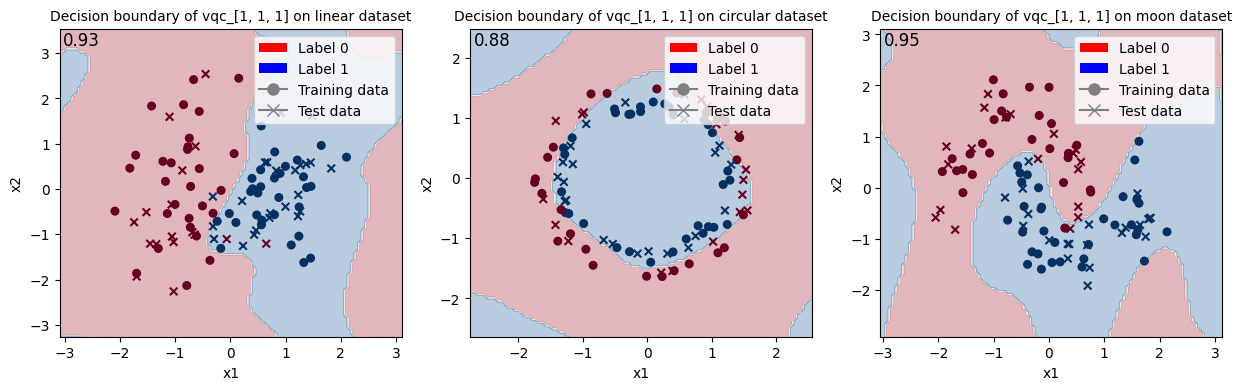

<Figure size 640x480 with 0 Axes>

In [26]:
# VQC [1, 1, 1]
args = Arguments(m, input_size, [1, 1, 1], activation, no_bunching, num_runs, n_epochs, batch_size, lr, alpha, betas, scale_type, regu_on)
vqc_111_results = train_vqc_multiple_runs(args)

Train MLP with wanted network type and show the decision boundary.

Linear training set: 60 samples, 2 features
Linear test set: 40 samples, 2 features
Circular training set: 60 samples, 2 features
Circular test set: 40 samples, 2 features
Moon training set: 60 samples, 2 features
Moon test set: 40 samples, 2 features

Training MLP (wide) with dataset linear (5 runs):
  Run 1/5, MLP has 17 parameters...


Training MLP with dataset linear (run1) - Loss: 0.0909, Test Acc: 0.8750: 100%|██████████| 100/100 [00:00<00:00, 112.64it/s]


  Run 2/5, MLP has 17 parameters...


Training MLP with dataset linear (run2) - Loss: 0.0875, Test Acc: 0.8750: 100%|██████████| 100/100 [00:00<00:00, 194.15it/s]


  Run 3/5, MLP has 17 parameters...


Training MLP with dataset linear (run3) - Loss: 0.1130, Test Acc: 0.8750: 100%|██████████| 100/100 [00:00<00:00, 185.09it/s]


  Run 4/5, MLP has 17 parameters...


Training MLP with dataset linear (run4) - Loss: 0.0766, Test Acc: 0.8750: 100%|██████████| 100/100 [00:00<00:00, 179.12it/s]


  Run 5/5, MLP has 17 parameters...


Training MLP with dataset linear (run5) - Loss: 0.0956, Test Acc: 0.8750: 100%|██████████| 100/100 [00:00<00:00, 191.60it/s]



Training MLP (wide) with dataset circular (5 runs):
  Run 1/5, MLP has 17 parameters...


Training MLP with dataset circular (run1) - Loss: 0.3526, Test Acc: 0.6750: 100%|██████████| 100/100 [00:00<00:00, 190.90it/s]


  Run 2/5, MLP has 17 parameters...


Training MLP with dataset circular (run2) - Loss: 0.4073, Test Acc: 0.5250: 100%|██████████| 100/100 [00:00<00:00, 191.22it/s]


  Run 3/5, MLP has 17 parameters...


Training MLP with dataset circular (run3) - Loss: 0.3350, Test Acc: 0.5250: 100%|██████████| 100/100 [00:00<00:00, 189.31it/s]


  Run 4/5, MLP has 17 parameters...


Training MLP with dataset circular (run4) - Loss: 0.4522, Test Acc: 0.5250: 100%|██████████| 100/100 [00:00<00:00, 193.12it/s]


  Run 5/5, MLP has 17 parameters...


Training MLP with dataset circular (run5) - Loss: 0.4080, Test Acc: 0.5250: 100%|██████████| 100/100 [00:00<00:00, 203.75it/s]



Training MLP (wide) with dataset moon (5 runs):
  Run 1/5, MLP has 17 parameters...


Training MLP with dataset moon (run1) - Loss: 0.1438, Test Acc: 0.8250: 100%|██████████| 100/100 [00:00<00:00, 162.22it/s]


  Run 2/5, MLP has 17 parameters...


Training MLP with dataset moon (run2) - Loss: 0.1937, Test Acc: 0.8250: 100%|██████████| 100/100 [00:00<00:00, 149.37it/s]


  Run 3/5, MLP has 17 parameters...


Training MLP with dataset moon (run3) - Loss: 0.1865, Test Acc: 0.8500: 100%|██████████| 100/100 [00:00<00:00, 156.73it/s]


  Run 4/5, MLP has 17 parameters...


Training MLP with dataset moon (run4) - Loss: 0.1505, Test Acc: 0.8750: 100%|██████████| 100/100 [00:00<00:00, 152.77it/s]


  Run 5/5, MLP has 17 parameters...


Training MLP with dataset moon (run5) - Loss: 0.1886, Test Acc: 0.8250: 100%|██████████| 100/100 [00:00<00:00, 160.95it/s]


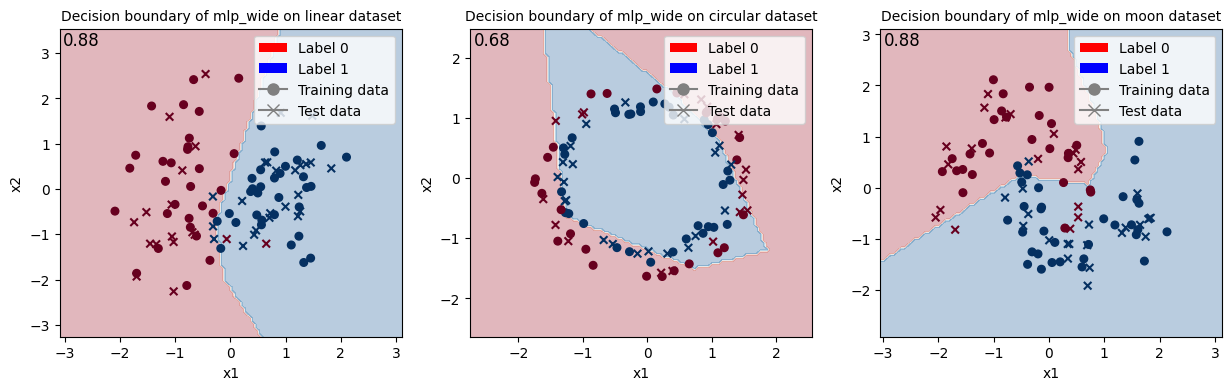

<Figure size 640x480 with 0 Axes>

In [29]:
# MLP
network_type = "wide"  # ["wide", "deep"]
mlp_results = train_mlp_multiple_runs(args, network_type=network_type)

Train SVM with wanted kernel type and show the decision boundary.

Linear training set: 60 samples, 2 features
Linear test set: 40 samples, 2 features
Circular training set: 60 samples, 2 features
Circular test set: 40 samples, 2 features
Moon training set: 60 samples, 2 features
Moon test set: 40 samples, 2 features

Training SVM (linear) with dataset linear (5 runs):
  Run 1/5, SVM (linear)...
  Run 2/5, SVM (linear)...
  Run 3/5, SVM (linear)...
  Run 4/5, SVM (linear)...
  Run 5/5, SVM (linear)...

Training SVM (linear) with dataset circular (5 runs):
  Run 1/5, SVM (linear)...
  Run 2/5, SVM (linear)...
  Run 3/5, SVM (linear)...
  Run 4/5, SVM (linear)...
  Run 5/5, SVM (linear)...

Training SVM (linear) with dataset moon (5 runs):
  Run 1/5, SVM (linear)...
  Run 2/5, SVM (linear)...
  Run 3/5, SVM (linear)...
  Run 4/5, SVM (linear)...
  Run 5/5, SVM (linear)...


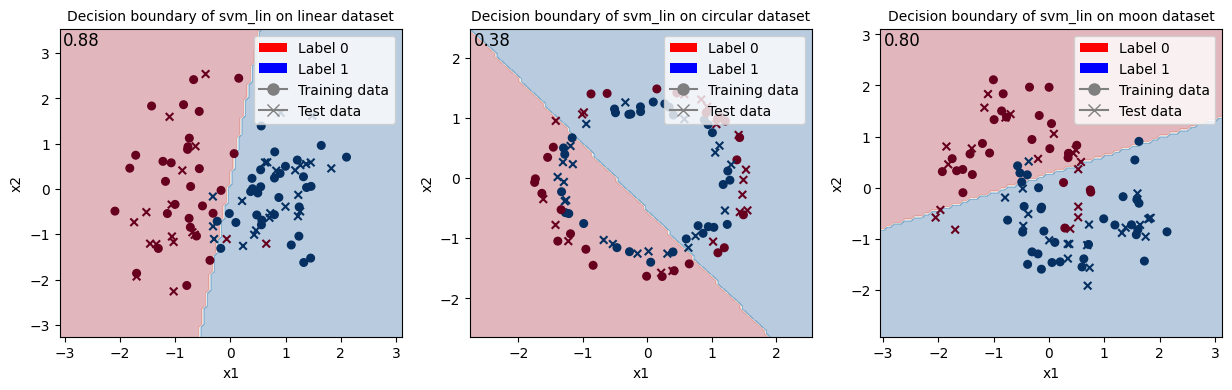

<Figure size 640x480 with 0 Axes>

In [30]:
# SVM
kernel_type = "lin"  # ["lin", "rbf"]
svm_results = train_svm_multiple_runs(args, kernel_type=kernel_type)

## 5. Plot training curves

In [36]:
def visualize_results(results, model_name):
    """Plot training curves with average and envelope for each dataset"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    datasets = ["linear", "circular", "moon"]
    datasets_maj = ["Linear", "Circular", "Moon"]
    colors = ["red", "green", "blue"]

    # Plot each metric
    for i, dataset in enumerate(datasets):
        color = colors[i]
        linestyle = '-'

        # Get data from all runs
        losses_runs = [run['losses'] for run in results[dataset]['runs']]
        train_acc_runs = [run['train_accuracies'] for run in results[dataset]['runs']]
        test_acc_runs = [run['test_accuracies'] for run in results[dataset]['runs']]

        # Calculate mean values across all runs
        epochs = len(losses_runs[0])
        mean_losses = [sum(run[i] for run in losses_runs) / len(losses_runs) for i in range(epochs)]
        mean_train_acc = [sum(run[i] for run in train_acc_runs) / len(train_acc_runs) for i in range(epochs)]
        mean_test_acc = [sum(run[i] for run in test_acc_runs) / len(test_acc_runs) for i in range(epochs)]

        # Calculate min and max values for the envelope
        min_losses = [min(run[i] for run in losses_runs) for i in range(epochs)]
        max_losses = [max(run[i] for run in losses_runs) for i in range(epochs)]

        min_train_acc = [min(run[i] for run in train_acc_runs) for i in range(epochs)]
        max_train_acc = [max(run[i] for run in train_acc_runs) for i in range(epochs)]

        min_test_acc = [min(run[i] for run in test_acc_runs) for i in range(epochs)]
        max_test_acc = [max(run[i] for run in test_acc_runs) for i in range(epochs)]

        # Plot mean lines
        ax1.plot(mean_losses, label=datasets_maj[i], color=color, linestyle=linestyle, linewidth=2)
        ax2.plot(mean_train_acc, label=datasets_maj[i], color=color, linestyle=linestyle, linewidth=2)
        ax3.plot(mean_test_acc, label=datasets_maj[i], color=color, linestyle=linestyle, linewidth=2)

        # Plot envelopes (filled area between min and max)
        epochs_range = range(epochs)
        ax1.fill_between(epochs_range, min_losses, max_losses, color=color, alpha=0.2)
        ax2.fill_between(epochs_range, min_train_acc, max_train_acc, color=color, alpha=0.2)
        ax3.fill_between(epochs_range, min_test_acc, max_test_acc, color=color, alpha=0.2)

    # Customize plots
    for ax, title in zip([ax1, ax2, ax3], ['Training Loss', 'Training Accuracy', 'Test Accuracy']):
        ax.set_title(title + f" for a {model_name} \non different datasets", fontsize=14, pad=10)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(title.split()[-1], fontsize=12)
        ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
    plt.clf()
    return

Visualize results for VQC with initial state \[1, 0, 0].

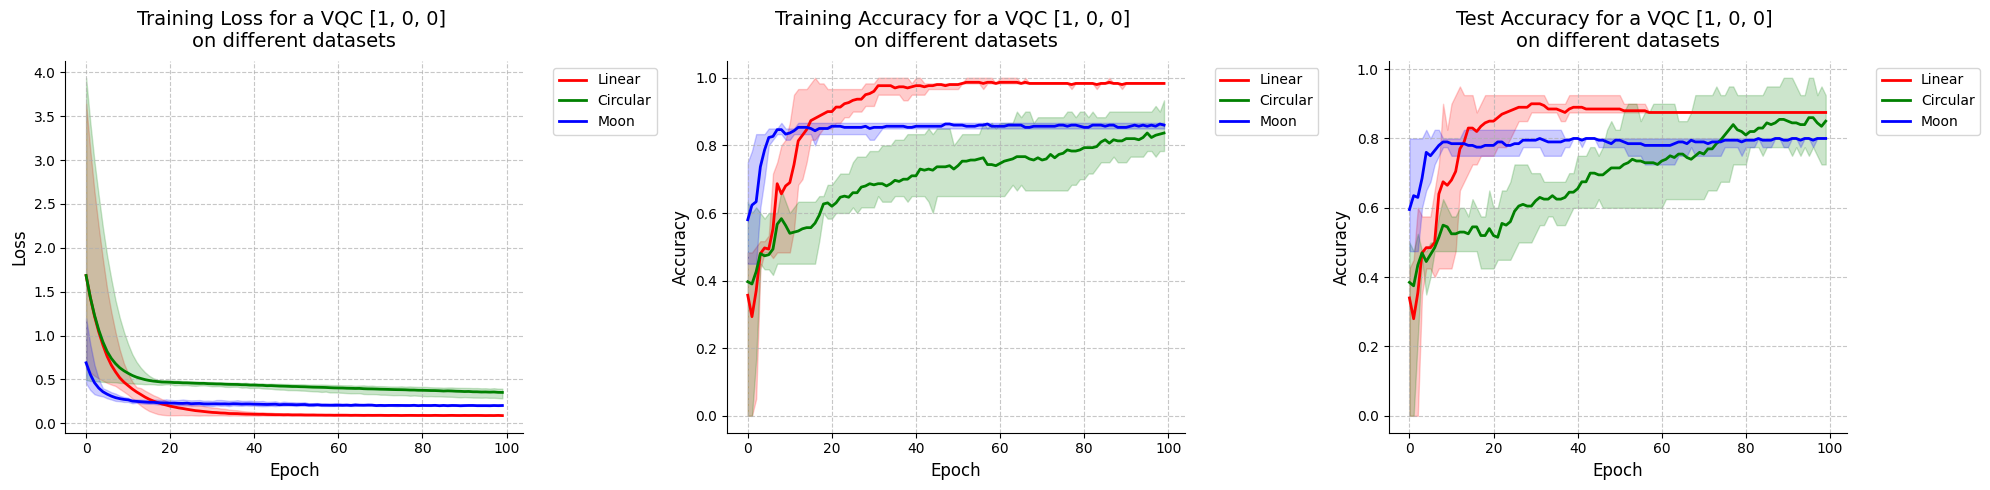

<Figure size 640x480 with 0 Axes>

In [37]:
visualize_results(vqc_100_results, "VQC [1, 0, 0]")

Visualize results for VQC with initial state \[1, 1, 1].

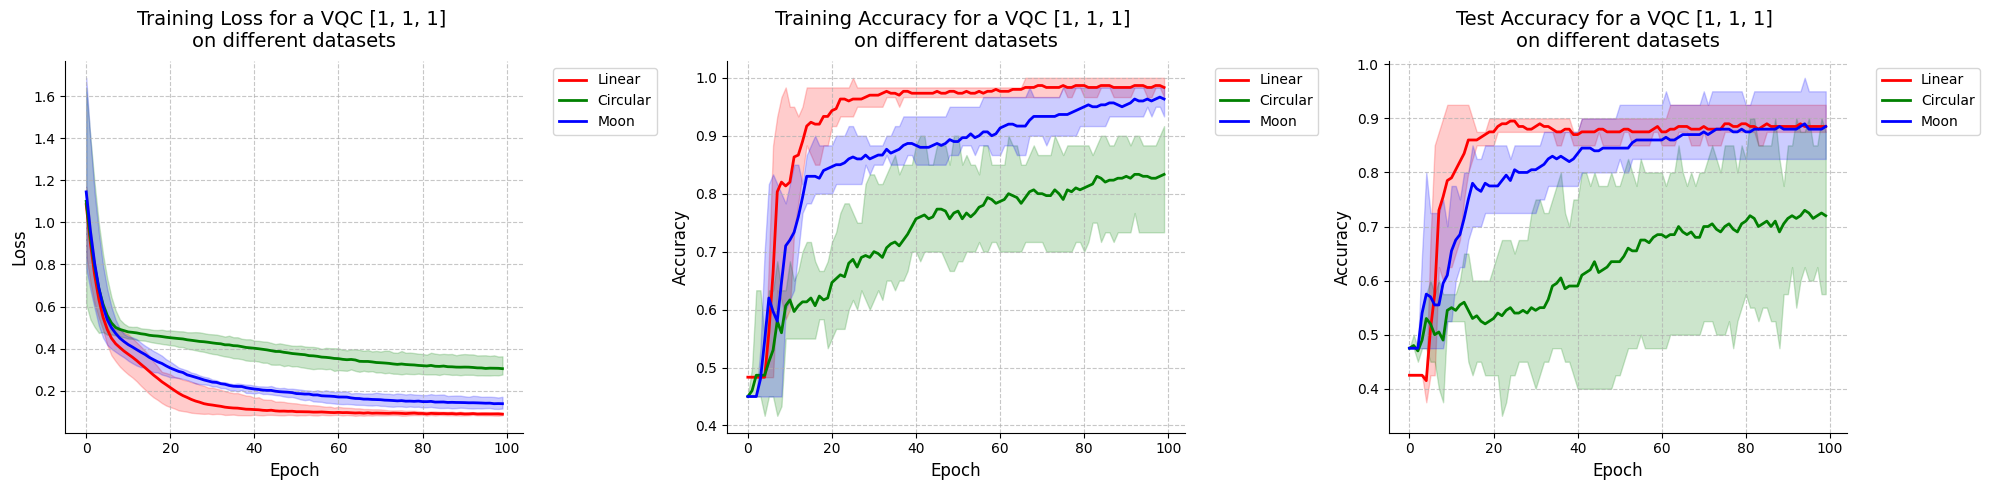

<Figure size 640x480 with 0 Axes>

In [38]:
visualize_results(vqc_111_results, "VQC [1, 1, 1]")

Visualize results for MLP.

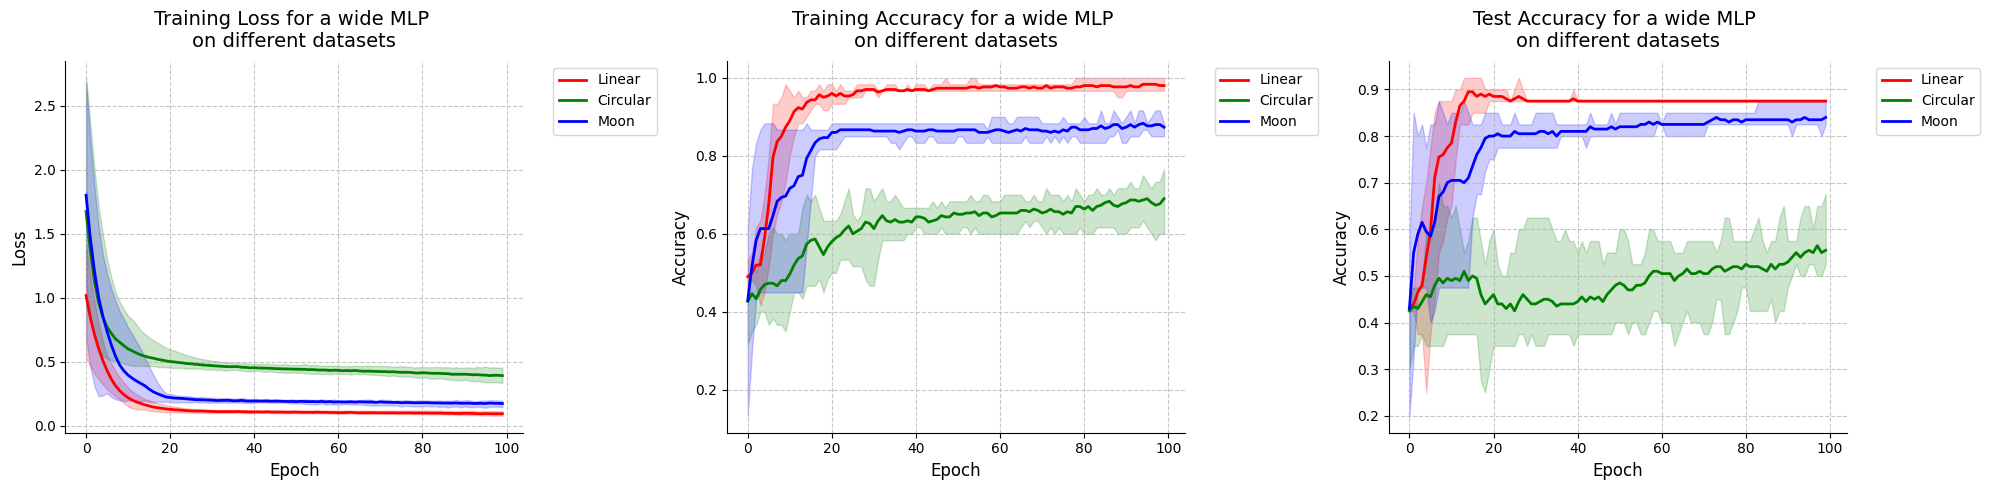

<Figure size 640x480 with 0 Axes>

In [39]:
visualize_results(mlp_results, "wide MLP")

We won't visualize results for the SVM since we don't have direct access at the losses and accuracies during the training. This is because we used the implementation of sklearn for this model.

## 6. Summary of results

In [40]:
def write_summary_statistics(all_results, args, model):
    """Print hyperparameters info and summary statistics for all datasets. Return average test accuracy and its standard deviation across several runs"""
    s = "----- Hyperparameters information -----\n"
    s += f"m = {args.m}\ninput_size = {args.input_size}\ninitial_state = {args.initial_state}\n\n"
    s += (f"activation = {args.activation}\nno_bunching = {args.no_bunching}\nnum_runs = {args.num_runs}\nn_epochs = "
          f"{args.n_epochs}\nbatch_size = {args.batch_size}\nlr = {args.lr}\nalpha = {args.alpha}\nbetas = {args.betas}"
          f"\nscale_type = {args.scale_type}\nregu_on = {args.regu_on}\n")
    s += f"\n----- Model Comparison Results -----\n"

    avg_accs = []
    std_accs = []

    for dataset_name, model_data in all_results.items():
        # Calculate statistics across runs
        final_accs = [run['final_test_acc'] for run in model_data['runs']]
        avg_acc = sum(final_accs) / len(final_accs)
        min_acc = min(final_accs)
        max_acc = max(final_accs)
        std_acc = (sum((acc - avg_acc) ** 2 for acc in final_accs) / len(final_accs)) ** 0.5

        avg_accs.append(avg_acc)
        std_accs.append(std_acc)

        s += f"{model} with dataset {dataset_name}:\n"
        s += f"  Final Test Accuracy: {avg_acc:.4f} ± {std_acc:.4f} (min: {min_acc:.4f}, max: {max_acc:.4f})\n\n"

    print(s)
    return avg_accs, std_accs

Summary statistics for VQC with initial state \[1, 0, 0].

In [41]:
vqc100_accs, vqc100_stds = write_summary_statistics(vqc_100_results, args, "VQC [1, 0, 0]")

----- Hyperparameters information -----
m = 3
input_size = 2
initial_state = [1, 1, 1]

activation = none
no_bunching = False
num_runs = 5
n_epochs = 100
batch_size = 32
lr = 0.02
alpha = 0.002
betas = (0.85, 0.999)
scale_type = /pi
regu_on = linear

----- Model Comparison Results -----
VQC [1, 0, 0] with dataset linear:
  Final Test Accuracy: 0.8750 ± 0.0000 (min: 0.8750, max: 0.8750)

VQC [1, 0, 0] with dataset circular:
  Final Test Accuracy: 0.8500 ± 0.0707 (min: 0.7250, max: 0.9250)

VQC [1, 0, 0] with dataset moon:
  Final Test Accuracy: 0.8000 ± 0.0000 (min: 0.8000, max: 0.8000)




Summary statistics for VQC with initial state \[1, 1, 1].


In [42]:
vqc111_accs, vqc111_stds = write_summary_statistics(vqc_111_results, args, "VQC [1, 1, 1]")

----- Hyperparameters information -----
m = 3
input_size = 2
initial_state = [1, 1, 1]

activation = none
no_bunching = False
num_runs = 5
n_epochs = 100
batch_size = 32
lr = 0.02
alpha = 0.002
betas = (0.85, 0.999)
scale_type = /pi
regu_on = linear

----- Model Comparison Results -----
VQC [1, 1, 1] with dataset linear:
  Final Test Accuracy: 0.8850 ± 0.0200 (min: 0.8750, max: 0.9250)

VQC [1, 1, 1] with dataset circular:
  Final Test Accuracy: 0.7200 ± 0.0954 (min: 0.5750, max: 0.8750)

VQC [1, 1, 1] with dataset moon:
  Final Test Accuracy: 0.8850 ± 0.0464 (min: 0.8250, max: 0.9500)




Summary statistics for MLP.


In [43]:
mlp_accs, mlp_stds = write_summary_statistics(mlp_results, args, "MLP")

----- Hyperparameters information -----
m = 3
input_size = 2
initial_state = [1, 1, 1]

activation = none
no_bunching = False
num_runs = 5
n_epochs = 100
batch_size = 32
lr = 0.02
alpha = 0.002
betas = (0.85, 0.999)
scale_type = /pi
regu_on = linear

----- Model Comparison Results -----
MLP with dataset linear:
  Final Test Accuracy: 0.8750 ± 0.0000 (min: 0.8750, max: 0.8750)

MLP with dataset circular:
  Final Test Accuracy: 0.5550 ± 0.0600 (min: 0.5250, max: 0.6750)

MLP with dataset moon:
  Final Test Accuracy: 0.8400 ± 0.0200 (min: 0.8250, max: 0.8750)




Summary statistics for SVM.

In [44]:
svm_accs, svm_stds = write_summary_statistics(svm_results, args, "SVM")

----- Hyperparameters information -----
m = 3
input_size = 2
initial_state = [1, 1, 1]

activation = none
no_bunching = False
num_runs = 5
n_epochs = 100
batch_size = 32
lr = 0.02
alpha = 0.002
betas = (0.85, 0.999)
scale_type = /pi
regu_on = linear

----- Model Comparison Results -----
SVM with dataset linear:
  Final Test Accuracy: 0.8750 ± 0.0000 (min: 0.8750, max: 0.8750)

SVM with dataset circular:
  Final Test Accuracy: 0.3750 ± 0.0000 (min: 0.3750, max: 0.3750)

SVM with dataset moon:
  Final Test Accuracy: 0.8000 ± 0.0000 (min: 0.8000, max: 0.8000)




## 7. Comparison of results

Let's compare the obtained test accuracies for each model on each dataset.

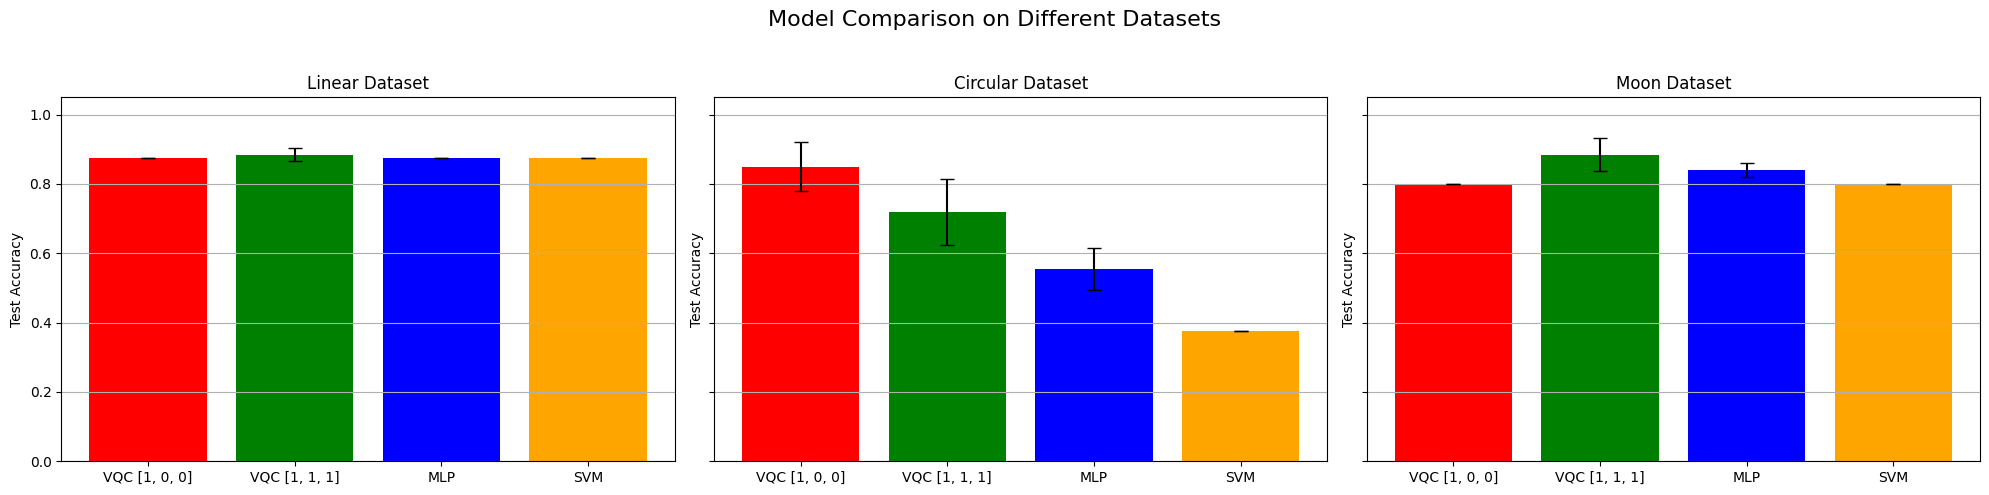

In [45]:
def compare_accuracies(accuracies, stds):
    """Visual comparison the test accuracy of the different models used on the three datasets"""
    fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
    datasets = ["Linear", "Circular", "Moon"]
    colors = ["red", "green", "blue", "orange"]
    models = ["VQC [1, 0, 0]", "VQC [1, 1, 1]", "MLP", "SVM"]

    accuracies = np.array(accuracies)
    stds = np.array(stds)

    x = np.arange(len(models))  # X positions for bars

    for i, ax in enumerate(axs):
        accs_for_dataset = accuracies[:, i]
        stds_for_dataset = stds[:, i]

        ax.bar(x, accs_for_dataset, yerr=stds_for_dataset, capsize=5,
               color=colors, tick_label=models)
        ax.set_title(f"{datasets[i]} Dataset")
        ax.set_ylabel("Test Accuracy")
        ax.set_ylim(0, 1.05)  # accuracies range from 0 to 1
        ax.grid(True, axis='y')

    fig.suptitle("Model Comparison on Different Datasets", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig("./results/test_accuracy_comparison.png")  # To save the figure locally
    plt.show()


accuracies = [vqc100_accs, vqc111_accs, mlp_accs, svm_accs]
stds = [vqc100_stds, vqc111_stds, mlp_stds, svm_stds]
compare_accuracies(accuracies, stds)

When looking at these results and at the decision boundaries of the different models, we can come to similar conclusions from the ones in [Fock State-enhanced Expressivity of Quantum Machine Learning Models](https://arxiv.org/abs/2107.05224). First off, concerning VQCs, the classification boundaries of the VQC become more complex as the number of photon used increases. This demonstrates the increasing expressive power of quantum circuits. We see here, that this augment is only useful on the moon dataset for which the model with initial state \[1, 0, 0] does not have enough complexity. The more expressive VQC with initial state \[1, 1, 1] performs better on this dataset, however it performs worse on the circular dataset than its rival. This could be explained by overfitting, and it shows that more expressive power is not necessarily better.

Then, we can observe that a linear model (such as linear SVM) can obtain the best (or equal to best) performance on the linear dataset, without surprise.

Finally, when comparing the results from the VQCs (16 and 23 parameters for initial states \[1, 0, 0] and \[1, 1, 1] respectively) with the ones from the MLP (17 parameters) that has a comparable number of parameters, they are equivalent because they have the same performance on the linear dataset, the VQCs are slightly better on the circular dataset and the MLP is slightly better on the moon dataset.